In [ ]:
import pandas as pd
from pandas import Timedelta
import numpy as np

from datasets import Dataset

In [2]:
fx = pd.read_csv('data/OANDA/EUR_USD.csv')

fx['datetime'] = pd.to_datetime(fx['datetime'], infer_datetime_format = True)

In [3]:
fx.duplicated(subset = 'datetime').any()

False

In [4]:
# convert to eastern time so that day light savings can be removed then back to UTC
fx['datetime'] = fx['datetime'].dt.tz_localize(
    'US/Eastern', ambiguous = fx['datetime'].astype(bool), nonexistent='shift_forward'
)
fx['datetime'] = fx['datetime'].dt.tz_convert(None) - Timedelta('5 hours')
assert not fx.duplicated(subset = 'datetime').any()

# Preprocessing

- Step 1: linearly interpolate gaps (shoot, not sure how to do this in parallel besides filling in all gaps and then getting rid of friday -> sunday
- Step 2: so we will go from 21:00 to 21:00 from sunday to friday
    - make a "trading day" feature starting from 21:00 of 
    - get rid of stragler days with no trades at end and beginning if the don't match up right
- Step 3: subtract the day's open at 21:00 from each day (group by day easy) -- let's not honestly...
- Step 4: make relative volume indicator using comparing real volume to groupby day's MA -- yeah I mean for now let's not
- Step 5: 60min HLC

- Step 6: create train, validation and test datasets
- Step 7: divide each column by their std (ungrouped) USING ONLY TRAINING SET MAKING SURE TO SAVE THIS NUMBER -- not for now


Make JSON:
- make the weekday and relative volume a feature
- make inputs_embeds a 2d array containing OHLCV and label 2D array of HLC (no day of week)
- store as JSON

In [5]:
# Linearly interpolate time gaps
fx = fx.set_index('datetime').asfreq('1min')
fx['close'] = fx['close'].fillna(method = 'ffill')
fx['volume'] = fx['volume'].fillna(0) # no volume in gaps (according to first rate data people)

# fill open high and low with most recent close
fx = fx.fillna({
    'open': fx['close'],
    'high': fx['close'],
    'low': fx['close']
})

In [6]:
# define the "trading day" as from starting on 9pm UTC of the previous day ending at 8:59pm UTC
fx['day'] = fx.index.dayofweek 
fx.loc[fx.between_time('22:00', '23:59').index, 'day'] += 1
fx['day'] = fx['day'] % 7 # sunday = 6, then + 1 would be 7 but we want that roll over to monday = 0

# ordinal trading day since start of data (just for help in preprocessing)
fx['ordinal_day'] = (fx['day'] != fx['day'].shift()).cumsum()

<AxesSubplot:>

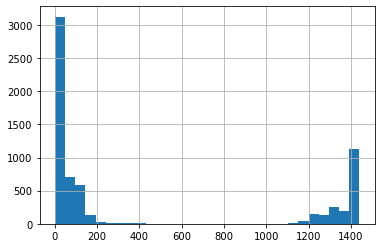

In [7]:
# look at distribution of how many 0 volume minute
(fx['volume'] == 0.).groupby(fx['ordinal_day']).sum().hist(bins = 30)

In [8]:
# let's just arbitrary say there should be less than 100 zero volume -- shouldn't really mattter in the end
voluminous_index = (fx['volume'] == 0.).groupby(fx['ordinal_day']).filter(lambda x: x.sum() < 200).index
fx = fx.loc[voluminous_index]

In [9]:
# quick sanity check of data 
fx.between_time('21:59', '22:01')

,close,high,low,open,volume,day,ordinal_day
datetime,,,,,,,
2005-01-02 21:59:00,1.35475,1.35475,1.35475,1.35475,0.0,6,1
2005-01-02 22:00:00,1.35475,1.35475,1.35475,1.35475,0.0,0,2
2005-01-02 22:01:00,1.35475,1.35475,1.35475,1.35475,0.0,0,2
2005-01-03 21:59:00,1.34640,1.34650,1.34630,1.34650,6.0,0,2
2005-01-03 22:00:00,1.34650,1.34660,1.34640,1.34640,7.0,1,3
...,...,...,...,...,...,...,...
2022-10-30 22:00:00,0.99563,0.99567,0.99552,0.99562,86.0,0,6512
2022-10-30 22:01:00,0.99563,0.99568,0.99555,0.99560,94.0,0,6512
2022-10-31 21:59:00,0.98838,0.98839,0.98837,0.98837,7.0,0,6512


# All data

In [1]:
import os
import pandas as pd
from pandas import Timedelta
import numpy as np

import datasets
from datasets import Dataset, concatenate_datasets

# Start with processing all CSVs to datasets

In [2]:
def make_dataset(filename, periods = [5, 10, 15, 20, 30, 45, 60, 90, 120], num_cuts = 10, return_df = False):
    fx = pd.read_csv(filename)
    
    fx['datetime'] = pd.to_datetime(fx['datetime'], infer_datetime_format = True)
    fx = fx[fx['datetime'].dt.year >= 2009].reset_index(drop = True)
    
    # convert to eastern time so that day light savings can be removed then back to UTC
    fx['datetime'] = fx['datetime'].dt.tz_localize(
        'US/Eastern', ambiguous = fx['datetime'].astype(bool), nonexistent='shift_forward'
    )
    fx['datetime'] = fx['datetime'].dt.tz_convert(None) - Timedelta('5 hours')
    fx = fx.drop_duplicates(subset = 'datetime', keep = 'last')
    assert not fx.duplicated(subset = 'datetime').any()
    
    # Linearly interpolate time gaps
    fx = fx.set_index('datetime').asfreq('1min')
    fx['close'] = fx['close'].fillna(method = 'ffill')
    fx['volume'] = fx['volume'].fillna(0) # no volume in gaps (according to first rate data people)

    # fill open high and low with most recent close
    fx = fx.fillna({
        'open': fx['close'],
        'high': fx['close'],
        'low': fx['close']
    })
    
    # define the "trading day" as from starting on 9pm UTC of the previous day ending at 8:59pm UTC
    fx['day'] = fx.index.dayofweek 
    fx.loc[fx.between_time('22:00', '23:59').index, 'day'] += 1
    fx['day'] = fx['day'] % 7 # sunday = 6, then + 1 would be 7 but we want that roll over to monday = 0

    # ordinal trading day since start of data (just for help in preprocessing)
    fx['ordinal_day'] = (fx['day'] != fx['day'].shift()).cumsum()
    
    # let's just arbitrary say there should be less than 200 zero volume -- shouldn't really mattter in the end
    voluminous_index = (fx['volume'] == 0.).groupby(fx['ordinal_day']).filter(lambda x: x.sum() < 400).index
    fx = fx.loc[voluminous_index]

    # make deciles for possible outcomes
    # this may violate test-train split principles but require significant memorization from model
    futures = {}
    for i in periods:
        futures_name = f'future_diff{i}'
        future_diff = fx['close'].shift(-i) - fx['close']
        futures[futures_name] = future_diff

    futures_df = pd.DataFrame(futures)
    future_cols = futures_df.columns
    fx = pd.concat((fx, futures_df), axis = 1)

    # clean up data odditity of future columns coming from the future of non-consecutive days (i.e. no overnight trading)
    fx['day_break'] = ((fx['day'] != (fx['day']).shift(-1)) & (fx['day'] != (fx['day'] - 1).shift(-1)))
    for i in periods:
        futures_name = f'future_diff{i}'
        no_futures = fx[futures_name][
            fx.groupby('ordinal_day')['day_break'].transform('any')
        ].between_time(f'{21 - i // 60}:{59 - i % 60}', '21:59').index
        fx.loc[no_futures, futures_name] = 0
    
#     std_future_cols = "std_" + future_cols
#     fx[std_future_cols] = fx[future_cols] / fx.iloc[:int(len(fx) * .9)][future_cols].std()
    
    # form labels after overnight correction
    labels = {}
    cuts = {}
    for i in periods:
        futures_name = f'future_diff{i}'
        labels_name = f'label{i}'
        
        labels[labels_name] = pd.qcut(fx[futures_name], num_cuts, labels = False)
        cuts[i] = fx[futures_name].groupby(labels[labels_name]).median()
        
    labels_df = pd.DataFrame(labels)
    labels_df = labels_df.fillna(-100).astype(int)
    label_cols = labels_df.columns
    fx = pd.concat((fx, labels_df), axis = 1)
    
    
    # fix overnight labels to be -100 (i.e. ignored)
    for i in periods:
        labels_name = f'label{i}'
        no_futures = fx[futures_name][
            fx.groupby('ordinal_day')['day_break'].transform('any')
        ].between_time(f'{21 - i // 60}:{59 - i % 60}', '21:59').index
        fx.loc[no_futures, labels_name] = -100

    # will be returned at the end so we know what the categories represent
    cuts = pd.DataFrame(cuts)
    
    features = ['open', 'high', 'low', 'close']
    
    # de mean prices by subtracting the first close of the day
    fx[features] = fx[features].subtract(
        fx.groupby('ordinal_day')['close'].transform('first'), axis = 0
    )

    # de standardize based on first 90% of data (to avoid test train split issue)
    stds = fx.iloc[:int(len(fx) * .9)][features].std(axis = 0)
    fx[features] = fx[features].div(stds, axis = 1)

    # get rid of first day and last day due to data incompleteness
    fx = fx.drop(fx[fx['ordinal_day'] == fx['ordinal_day'].min()].index)
    fx = fx.drop(fx[fx['ordinal_day'] == fx['ordinal_day'].max()].index)
    
    if return_df:
        return fx

    ohlcv = fx[features].values.reshape(-1, 1440, len(features))
    labels = fx[label_cols].values.reshape(-1, 1440, len(periods))
    future = fx[future_cols].values.reshape(-1, 1440, len(periods))
#     std_future = fx[std_future_cols].values.reshape(-1, 1440, len(periods))
    
    # save some memory
    del fx
    
#     ds = Dataset.from_dict({"ohlcv": ohlcv, "labels": labels, "future": future, "std_future": std_future})
    ds = Dataset.from_dict({"ohlcv": ohlcv, "labels": labels, "future": future})
    
    return ds, cuts, stds

In [3]:
data_dir = './data/OANDA/'
os.listdir(data_dir)

['AUD_CAD.csv',
 'AUD_JPY.csv',
 'AUD_NZD.csv',
 'AUD_USD.csv',
 'EUR_AUD.csv',
 'EUR_CHF.csv',
 'EUR_GBP.csv',
 'EUR_JPY.csv',
 'EUR_NZD.csv',
 'EUR_USD.csv',
 'GBP_AUD.csv',
 'GBP_CAD.csv',
 'GBP_CHF.csv',
 'GBP_JPY.csv',
 'GBP_USD.csv',
 'NZD_JPY.csv',
 'NZD_USD.csv',
 'USD_CAD.csv',
 'USD_CHF.csv',
 'USD_JPY.csv']

In [4]:
majors = [
    'AUD_USD.csv',
    'EUR_CHF.csv',
    'EUR_GBP.csv',
    'EUR_JPY.csv',
    'EUR_USD.csv',
    'GBP_JPY.csv',
    'GBP_USD.csv',
    'USD_CAD.csv',
    'USD_CHF.csv',
    'USD_JPY.csv'
]

In [5]:
# for file in majors: # if only majors are wanted
for file in os.listdir(data_dir):
    dataset, cuts, stds = make_dataset(data_dir + file)
    dataset.save_to_disk(f"data/OANDA_DS/{file[:7]}.ds")
    cuts.to_csv(f"data/OANDA_DS/{file[:7]}.ds/cuts.csv", index = False)
    stds.to_csv(f"data/OANDA_DS/{file[:7]}.ds/stds.csv", index = False)
    print(file, end = '\r')

# Concat all datasets (done in 2 stages due to memory contraints)

In [6]:
data_dir = './data/OANDA_DS/'
os.listdir(data_dir)

['AUD_CAD.ds',
 'AUD_JPY.ds',
 'AUD_NZD.ds',
 'AUD_USD.ds',
 'EUR_AUD.ds',
 'EUR_CHF.ds',
 'EUR_GBP.ds',
 'EUR_JPY.ds',
 'EUR_NZD.ds',
 'EUR_USD.ds',
 'GBP_AUD.ds',
 'GBP_CAD.ds',
 'GBP_CHF.ds',
 'GBP_JPY.ds',
 'GBP_USD.ds',
 'NZD_JPY.ds',
 'NZD_USD.ds',
 'USD_CAD.ds',
 'USD_CHF.ds',
 'USD_JPY.ds']

In [7]:
# only majors for now
# eurusd at the end (as it will be used for the validation set)
filenames = [
    'AUD_USD.ds',
    'EUR_CHF.ds',
    'EUR_GBP.ds',
    'EUR_JPY.ds',
    'GBP_JPY.ds',
    'GBP_USD.ds',
    'USD_CAD.ds',
    'USD_CHF.ds',
    'USD_JPY.ds',
    'EUR_USD.ds'
]

In [8]:
# # top pairs with eurusd at the end
# filenames = [
#     'AUD_CAD.ds',
#     'AUD_JPY.ds',
#     'AUD_NZD.ds',
#     'AUD_USD.ds',
#     'EUR_AUD.ds',
#     'EUR_CHF.ds',
#     'EUR_GBP.ds',
#     'EUR_JPY.ds',
#     'EUR_NZD.ds',
#     'GBP_AUD.ds',
#     'GBP_CAD.ds',
#     'GBP_CHF.ds',
#     'GBP_JPY.ds',
#     'GBP_USD.ds',
#     'NZD_JPY.ds',
#     'NZD_USD.ds',
#     'USD_CAD.ds',
#     'USD_CHF.ds',
#     'USD_JPY.ds',
#     'EUR_USD.ds'
# ]

In [9]:
list_ds = [datasets.load_from_disk(data_dir + filename) for filename in filenames]

In [10]:
all_datasets = concatenate_datasets(list_ds)
all_datasets.save_to_disk("data/fx_days")

In [11]:
datasets.load_from_disk("data/fx_days")

Dataset({
    features: ['ohlcv', 'labels', 'future'],
    num_rows: 35329
})